# Catch Me If You Can (aka "Alice)

В этой задаче будем анализировать последовательность из нескольких веб-сайтов, посещенных подряд одним и тем же человеком, и определять, Элис это или взломщик (кто-то другой).

В обучающей выборке train_sessions.csv:
* Признаки site_i – это индексы посещенных сайтов (расшифровка дана в pickle-файле со словарем site_dic.pkl)
* Признаки time_j – время посещения сайтов site_j
* Целевой признак target – факт того, что сессия принадлежит Элис (то есть что именно Элис ходила по всем этим сайтам)

Подробное описание задачи и датасет по ссылке (https://www.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2)

Будем решать эту задачу с использованием только одного алгоритма - Logistic Regression - плюс немного feature engineering

In [2]:
import numpy as np
import pandas as pd

import os
import pickle #для расшифровки названий сайтов

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import OneHotEncoder

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler

In [3]:
SEED = 17

## Загрузка и обработка данных

In [4]:
# Укажем пути к файлам
PATH_DATA = r'C:\Users\user\Desktop\Courses\ODS\A2\catch-me-if-you-can'
path_train = os.path.join(PATH_DATA, 'train_sessions.csv')
path_test = os.path.join(PATH_DATA, 'test_sessions.csv')

In [5]:
# Посмотрим на данные
print(pd.read_csv(path_train).info(verbose=False))
pd.read_csv(path_train).head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253561 entries, 0 to 253560
Columns: 22 entries, session_id to target
dtypes: float64(9), int64(3), object(10)
memory usage: 42.6+ MB
None


,session_id,site1,time1,site2,time2,site3,time3,site4,time4,site5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
0,1,718,2014-02-20 10:02:45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,2,890,2014-02-22 11:19:50,941.0,2014-02-22 11:19:50,3847.0,2014-02-22 11:19:51,941.0,2014-02-22 11:19:51,942.0,...,2014-02-22 11:19:51,3847.0,2014-02-22 11:19:52,3846.0,2014-02-22 11:19:52,1516.0,2014-02-22 11:20:15,1518.0,2014-02-22 11:20:16,0
2,3,14769,2013-12-16 16:40:17,39.0,2013-12-16 16:40:18,14768.0,2013-12-16 16:40:19,14769.0,2013-12-16 16:40:19,37.0,...,2013-12-16 16:40:19,14768.0,2013-12-16 16:40:20,14768.0,2013-12-16 16:40:21,14768.0,2013-12-16 16:40:22,14768.0,2013-12-16 16:40:24,0
3,4,782,2014-03-28 10:52:12,782.0,2014-03-28 10:52:42,782.0,2014-03-28 10:53:12,782.0,2014-03-28 10:53:42,782.0,...,2014-03-28 10:54:42,782.0,2014-03-28 10:55:12,782.0,2014-03-28 10:55:42,782.0,2014-03-28 10:56:12,782.0,2014-03-28 10:56:42,0
4,5,22,2014-02-28 10:53:05,177.0,2014-02-28 10:55:22,175.0,2014-02-28 10:55:22,178.0,2014-02-28 10:55:23,177.0,...,2014-02-28 10:55:59,175.0,2014-02-28 10:55:59,177.0,2014-02-28 10:55:59,177.0,2014-02-28 10:57:06,178.0,2014-02-28 10:57:11,0


In [6]:
# Преобразуем данные столбцов time к типу datetime
# Определим тренировочный и тестовый датасеты

times = ['time{}'.format(i) for i in range(1, 11)] # список имён столбцов = time1 ... time10 
sites = ['site{}'.format(i) for i in range(1, 11)] # список имён столбцов = site1 ... site10 

train_df = pd.read_csv(path_train, index_col='session_id', parse_dates=times)
test_df = pd.read_csv(path_test, index_col='session_id', parse_dates=times)

# Отсортируем тренировочные данные по времени
train_df = train_df.sort_values(by='time1')

Данные, которые мы загрузили, представляют собой пользовательские сессии, отобранные таким образом, чтобы они были короче 30 минут и содержали не более 10 сайтов. То есть сеанс считается законченным, если пользователь посетил 10 веб-сайтов или если сеанс длился более 30 минут.

В df есть пропущенные значения. Это означает, что некоторые пользовательские сессии содержат менее десяти веб-сайтов. Заменим пустые значения на 0 и изменим типы столбцов на int.

In [7]:
# Заменим все пропущенные значения в site на 0
train_df[sites] = train_df[sites].fillna(0).astype(np.uint16)
test_df[sites] = test_df[sites].fillna(0).astype(np.uint16)

Загрузим словарь с названиями сайтов. Мы хотим, чтобы отображались названия сайтов, а не их числовая кодировка. Так будет удобнее интерпретировать данные

In [8]:
path_dic = r'C:\Users\user\Desktop\Courses\ODS\A2\catch-me-if-you-can\site_dic.pkl'
with open(path_dic, 'rb') as input_file:
    site_dict = pickle.load(input_file)

# Создадим dataframe для словаря
sites_dict = pd.DataFrame(list(site_dict.keys()), index=list(site_dict.values()), 
                          columns=['site'])
sites_dict.head()

,site
25075,www.abmecatronique.com
13997,groups.live.com
42436,majeureliguefootball.wordpress.com
30911,cdt46.media.tourinsoft.eu
8104,www.hdwallpapers.eu


## Предварительный анализ (EDA)

#### Топ сайтов

In [9]:
# Посмотрим на топ сайтов всего датасета
top_sites = pd.Series(train_df[sites].values.flatten()
                     ).value_counts().sort_values(ascending=False).head(5)
print(top_sites)
sites_dict.loc[top_sites.drop(0).index] # сайты с индексом "0" игнорируем (это наши пропущенные значения)

21     123776
0      122730
23      87619
782     77055
22      58258
dtype: int64


,site
21,www.google.fr
23,www.google.com
782,annotathon.org
22,apis.google.com


In [10]:
# Посмотрим на предпочтения Элис
top_Alice_sites = pd.Series(train_df[train_df.target == 1].values.flatten()
                           ).value_counts().sort_values(ascending=False).head(5)
sites_dict.loc[top_Alice_sites.index]

,site
1,fpdownload2.macromedia.com
77,i1.ytimg.com
80,s.youtube.com
76,www.youtube.com
29,www.facebook.com


Оказывается, предпочтения Элис отличаются от "среднего" пользователя в датасете

#### Теперь посмотрим на временные метки

In [48]:
# Создадим отдельный df для работы с временными рядами
time_df = pd.DataFrame(index=train_df.index)
time_df_test = pd.DataFrame(index=test_df.index)
time_df['target'] = train_df['target']

# Найдём начало и конец сессий
time_df['min'] = train_df[times].min(axis=1)
time_df['max'] = train_df[times].max(axis=1)

time_df_test['min'] = test_df[times].min(axis=1)
time_df_test['max'] = test_df[times].max(axis=1)

# Вычислим продолжительность сессий
time_df['seconds'] = (time_df['max'] - time_df['min']) / np.timedelta64(1, 's')

time_df.head()

,target,min,max,seconds
session_id,,,,
21669,0,2013-01-12 08:05:57,2013-01-12 08:05:57,0.0
54843,0,2013-01-12 08:37:23,2013-01-12 09:07:09,1786.0
77292,0,2013-01-12 08:50:13,2013-01-12 08:50:17,4.0
114021,0,2013-01-12 08:50:17,2013-01-12 08:50:20,3.0
146670,0,2013-01-12 08:50:20,2013-01-12 08:50:22,2.0


In [12]:
# Посмотрим на точечные оценки распределений длительности сессий Элис и других пользователей
time_df.groupby('target').describe()

seconds                                                       
           count        mean         std  min  25%   50%    75%     max
target                                                                 
0       251264.0  139.282372  296.653518  0.0  7.0  28.0  114.0  1800.0
1         2297.0   52.296474  153.309014  0.0  4.0  11.0   38.0  1763.0

In [13]:
print('Доля сессий Элис в выборке: {}'.format((1723 / (188447 + 1723) * 100)))

Доля сессий Элис в выборке: 0.9060314455487196


Глядя на эту таблицу, можем сделать следующие выводы:
- в среднем, сессии Элис короче остальных
- стандартное отклонение длительности сессии у Элис заметно меньше
- min и max продолжительность сессий у Элис и остальных совпадают
- доля сессий Элис в выборке менее 1% - данные несбалансированы

## Подготовка данных

Исключим метку класса target из тренировочного и валидационного наборов.

Затем объединим все три датасета (тренировочный, валидационный и тестовый) для того, чтобы во время подготовки данных не забыть применить какое-либо преобразование к одному из наборов. Во врмемя тренировки модели мы их опять разделим.

In [14]:
# Метка класса на тренировочном наборе
y_train = train_df['target']

# United dataframe of the initial data 
full_df = pd.concat([train_df.drop('target', axis=1), test_df])

# Индексы для последующего разделения
idx_split = train_df.shape[0]

Как мы убедились, у Элис есть свои любимые сайты. Разумно предположить, что чем чаще мы видим эти сайты в сеансе, тем выше вероятность того, что это сеанс Элис.

Используем эту догадку для построения базовой модели: будем использовать информацию только о посещённых сайтах в сеансе.

In [15]:
# Dataframe with indices of visited websites in session
full_sites = full_df[sites]
full_sites.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10
session_id,,,,,,,,,,
21669,56,55,0,0,0,0,0,0,0,0
54843,56,55,56,55,0,0,0,0,0,0
77292,946,946,951,946,946,945,948,784,949,946
114021,945,948,949,948,945,946,947,945,946,946
146670,947,950,948,947,950,952,946,951,946,947


Наши данные - это категориальные признаки. Преобразуем их таким образом, чтобы каждый сайт располагался в отдельном столбце, в котором будет записано значение, равное числу посещений этого сайта в сеансе.

Если мы вместо такого подхода применим One-Hot Encoding, то мы получим количество признаков, в разы превышающее объём всего датасета

In [16]:
# Преобразуем матрицу full_sites в вектор
sites_flatten = full_sites.values.flatten()

# Используем конструктор scipy.sparse.csr_matrix((data, indices, indptr))
full_sites_sparse = csr_matrix(([1] * sites_flatten.shape[0],
                                sites_flatten,
                                range(0, sites_flatten.shape[0] + 10, 10)))[:, 1:]

In [17]:
# Проверим размерность нашей матрицы
print (full_sites.shape, sites_dict.shape, full_sites_sparse.shape, sep='\n')

(336358, 10)
(48371, 1)
(336358, 48371)


In [41]:
# Выделим тренировочный датасет для исследований
X_train = full_sites_sparse[ : idx_split, :]
X_test = full_sites_sparse[idx_split :, :]

### Тренировка базовой модели

Создадим функцию, которая будет принимать тренировочные данные, выполнять подгонку алгоритма, выполнять кросс-валидацию и возвращать ROC-AUC

In [19]:
def auc_cross_val(X, y, C=1.0, seed=17): 
    # Определим алгоритм
    lr = LogisticRegression(C=C, random_state=seed, solver='liblinear')
    
    # Перекрёстная проверка
    time_split = TimeSeriesSplit(n_splits=10)
    cv_scores = cross_val_score(lr, X, y, cv=time_split, scoring='roc_auc', n_jobs=-1)
    
    print('CV scores', cv_scores)
    print('CV mean: {} \nCV std: {}'.format(cv_scores.mean(), cv_scores.std()))

In [20]:
print (X_train.shape, y_train.shape, sep='\n')

(253561, 48371)
(253561,)


In [21]:
%%time
# Из подготовленной для построения модели разреженной матрицы full_sites_sparse
# (которая, как мы помним, содержит тестовый набор) выделим X_train
X_train = full_sites_sparse[:idx_split, :]

# Посчитаем метрику
print(auc_cross_val(X_train, y_train))

CV scores [ 0.84302736  0.66887219  0.86511658  0.94558421  0.83316455  0.87934778
  0.92414115  0.85988266  0.92415655  0.91467266]
CV mean: 0.8657965703859689 
CV std: 0.07493095880442198
None
Wall time: 10.4 s


Для базовой модели получаем низкое качество и большую дисперсию на каждом из фолдов.
Нам нужно улучшить нашу базовую модель.

### Feature Engineering

Обратимся к временным меткам. Посмотрим на новые бинарные признаки: утро, день, вечер и ночь

In [22]:
session_start_hour = time_df['min'].apply(lambda ts: ts.hour).values
morning = ((session_start_hour >= 7) & (session_start_hour <= 11)).astype('int')
day = ((session_start_hour >= 12) & (session_start_hour <= 18)).astype('int')
evening = ((session_start_hour >= 19) & (session_start_hour <= 23)).astype('int')
night = ((session_start_hour >= 0) & (session_start_hour <= 6)).astype('int')

pd.crosstab([morning, day, evening, night], y_train, rownames=['morning', 'day', 'evening', 'night'])

target                          0     1
morning day evening night              
0       0   1       0        7251     0
        1   0       0      122129  2256
1       0   0       0      121884    41

Будет удобно оформить код из ячейки выше в виде отдельной функции, которая будет также добавлять новые признаки к уже имеющимся

In [23]:
def add_time_features(X_train, time_df, add_hour=True):
    # Повторим код для частей суток
    hour = time_df['min'].apply(lambda ts: ts.hour).values
    morning = ((hour >= 7) & (hour <= 11)).astype('int').astype('int').reshape(-1, 1)
    day = ((hour >= 12) & (hour <= 18)).astype('int').astype('int').reshape(-1, 1)
    evening = ((hour >= 19) & (hour <= 23)).astype('int').astype('int').reshape(-1, 1)
    night = ((hour >= 0) & (hour <=6)).astype('int').astype('int').reshape(-1, 1)
    
    objects_to_hstack = [X_train, morning, day, evening, night]

    # для гибкости добавим дополнительный признак "час" и нормируем его (разделим на 24)
    if add_hour:
        objects_to_hstack.append(hour.astype('int').reshape(-1, 1) / 24)
        
    X = hstack(objects_to_hstack)
    return X

In [24]:
# Новая модель с признаками "утро", "день", "вечер" и "ночь"
X_day = add_time_features(X_train, time_df, add_hour=False)
auc_cross_val(X_day, y_train, C=1.0, seed=17)

CV scores [ 0.88725321  0.77114832  0.91843332  0.96686423  0.89841952  0.93935409
  0.94986713  0.9257252   0.94883578  0.94533923]
CV mean: 0.9151240009689865 
CV std: 0.053318694806875074


In [25]:
# Та же можедель + признак "час"
X_day_hour = add_time_features(X_train, time_df, add_hour=True)
auc_cross_val(X_day_hour, y_train, C=1.0, seed=17)

CV scores [ 0.86548326  0.74879003  0.9402764   0.97463853  0.89340214  0.95303947
  0.95019127  0.93270476  0.9631624   0.95995515]
CV mean: 0.918164340185128 
CV std: 0.06479129400048507


In [26]:
# Проверим, на всякий случай, размерность нашей новой тренировочной матрицы
X_day.shape[1] - X_train.shape[1]

4

Видим, что заметно повысилось качество и снизилась дисперсия. Модель с дополнительным признаком "час" совсем немного добавляет к качеству, но при этом повышает дисперсию - откажемся от этого признака.

Разделение суток на части положительно сказалось на модели. Применим этот же подход к неделям и годам, т.е. разделим их на дни и месяцы соответственно 

In [27]:
def add_day_month(X_train, time_df):
    # Закодируем дни недели и месяцы года
    day_of_week = time_df['min'].apply(lambda t: t.weekday()).values.reshape(-1, 1)
    month = time_df['min'].apply(lambda t: t.month).values.reshape(-1, 1)
    
    enc = OneHotEncoder()
    day_of_week_enc = enc.fit_transform(day_of_week)
    month_enc = enc.fit_transform(month)
    
    objects_to_hstack = [X_train, day_of_week_enc, month_enc]
        
    X = hstack(objects_to_hstack)
    return X

In [29]:
# Проверим качество
X_day_month = add_day_month(X_train, time_df)
auc_cross_val(X_day_month, y_train, C=1.0, seed=17)

C:\Users\user\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used

CV scores [ 0.81027455  0.75929301  0.8462321   0.95427793  0.85026478  0.9401095
  0.92593397  0.93226188  0.83444536  0.95320631]
CV mean: 0.8806299391459549 
CV std: 0.06546624116887835


In [31]:
# Проверим, на всякий случай, размерность нашей новой тренировочной матрицы
X_day_month.shape[1] - X_train.shape[1]

19

Оказывается, новые метки дня недели и месяца бесполезны.

Обратимся теперь непосредственно к Элис и её любимым часам интернет-сёрфинга.

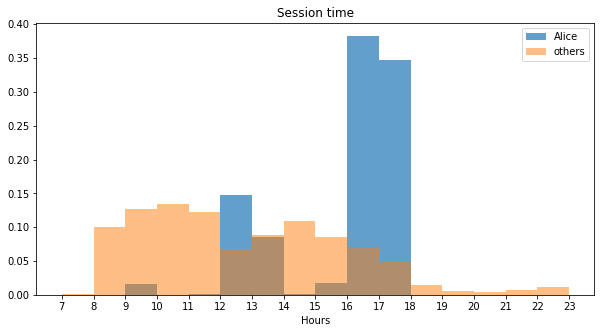

In [32]:
# Построим гистограмму для часов начала сессий
plt.subplots(figsize=(10,5))
plt.hist(time_df[time_df['target'] == 1]['min'].apply(lambda x: x.hour), density=True, alpha=0.7, bins=9)
plt.hist(time_df[time_df['target'] == 0]['min'].apply(lambda x: x.hour), density=True, alpha=0.5, bins=16)
plt.xticks(np.arange(7,24))
plt.xlabel('Hours')
plt.legend(['Alice', 'others'])
plt.title('Session time');

In [33]:
# Вспомним, как выглядели точечные оценки распределений длительности сессий Элис и других пользователей
time_df.groupby('target').describe()

seconds                                                       
           count        mean         std  min  25%   50%    75%     max
target                                                                 
0       251264.0  139.282372  296.653518  0.0  7.0  28.0  114.0  1800.0
1         2297.0   52.296474  153.309014  0.0  4.0  11.0   38.0  1763.0

Добавим два новых бинарных признака. Первый - Alice_hour - будет принимать значения 1, если сессия началась в 12-13 и 16-18 часов. Эти часы, как ввидно на гистограмме, характерны для Элис и менее характерны для остальных.

Второй бинарный признак - Alice_duration - будет принимать значения 1, если продолжительность сессии составляет, ну, скажем, от 30 до 60 секунд. В этот интервал попадает как среднее значение, так и 75% перцентиль.

Как обычно, определим новую функцию

In [34]:
def add_Alice_time(X_train, time_df):
    hour = time_df['min'].apply(lambda ts: ts.hour).values
    duration = time_df['seconds'].values
    Alice_hour = ((hour >= 12) & (hour <= 13) & (hour >= 16) & (hour <= 18)).astype('int').reshape(-1, 1)
    Alice_duration = ((duration >= 30) & (duration <= 60)).astype('int').reshape(-1, 1)
      
    objects_to_hstack = [X_train, Alice_hour, Alice_duration]
        
    X = hstack(objects_to_hstack)
    return X

In [35]:
# Проверим качество
X_Alice_time = add_Alice_time(X_train, time_df)
auc_cross_val(X_Alice_time, y_train, C=1.0, seed=17)

CV scores [ 0.83630084  0.66725134  0.86633225  0.94791802  0.83227765  0.88115693
  0.92306016  0.85989972  0.92422325  0.91459337]
CV mean: 0.8653013521197706 
CV std: 0.0758288391023734


Опять без улучшений.

Оставим feature engineering и постараемся повысить качество нашей лучшей модели (с признаками "утро", "день", "вечер", "ночь") подбором гиперпараметров.

### Parameter Tuning

Подберём оптимальные параметры алгоритма LogisticRegression

In [36]:
lr = LogisticRegression(random_state=SEED, solver='liblinear')

param_grid = {'C': np.logspace(-2, 2, 10),
             'penalty': ('l1', 'l2')}
time_split = TimeSeriesSplit(n_splits=5)
optimizer = GridSearchCV(estimator=lr, param_grid=param_grid,
                         scoring='roc_auc', n_jobs=-1, cv=time_split, verbose=1)

In [49]:
# Определим тренировочный и тестовый датасеты
X_final = add_time_features(X_train, time_df, add_hour=False)
X_test = add_time_features(X_test, time_df_test, add_hour=False)

In [38]:
optimizer.fit(X_final, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  7.1min finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
       error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=17, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': array([  1.00000e-02,   2.78256e-02,   7.74264e-02,   2.15443e-01,
         5.99484e-01,   1.66810e+00,   4.64159e+00,   1.29155e+01,
         3.59381e+01,   1.00000e+02]), 'penalty': ('l1', 'l2')},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=1)

In [39]:
print(optimizer.score(X_final, y_train))
print(optimizer.best_params_)

0.983733655784
{'C': 0.59948425031894093, 'penalty': 'l1'}


Т.к. GridSearchCV не только подбирает лучшие параметры, но и автоматически строит новую модель
на всём обучающем датасете, мы просто передадим результат предсказаний функции для их записи в файл

In [50]:
y_test = optimizer.predict_proba(X_test)[:, 1]

In [51]:
def write_to_submission_file(predicted_labels, out_file, target='target', index_label="session_id"):
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [52]:
write_to_submission_file(y_test, 'Alice.csv')